# **Binary Matrix Factorization Algorithm**

Matrix factorization is a collaborative filtering method used to predict missing entries in the user-item interaction matrix by decomposing it into two low-dimensional matrices:  Q (user embeddings) and P (item embeddings).

    https://web.stanford.edu/~rezab/nips2014workshop/submits/logmat.pdf


##### Initialize Matrices
- Randomly initialize  Q  and  P 
- Alternatively, use metadata embeddings to initialize these matrices.

---

##### Optimize for Loss Function
For binary interaction, we define the predicted probability of interaction $\hat{r}_{ui}$ using the sigmoid function:
$$
\hat{r}_{ui} = \sigma(\mathbf{q}_i^\top \mathbf{p}_u) = \frac{1}{1 + e^{-\mathbf{q}_i^\top \mathbf{p}_u}}
$$

The binary cross-entropy loss becomes:
$$
L = -\sum_{(u, i) \in R} \left( r_{ui} \log(\hat{r}_{ui}) + (1 - r_{ui}) \log(1 - \hat{r}_{ui}) \right) 
+ \lambda \left( \|\mathbf{q}_i\|^2 + \|\mathbf{p}_u\|^2 \right)
$$

Where:
- $r_{ui} \in \{0, 1\}$ is the observed interaction (binary).
- $\hat{r}_{ui}$ is the predicted probability of interaction.
- $\lambda$ is the regularization parameter.




##### Iterative Updates
- Update Q and P alternately to minimize the loss function L.
- Common optimization techniques include:
  
  
  - **Alternating Least Squares (ALS):**
  
    - Fix P and solve for Q, then fix Q and solve for P.
  
  - **Stochastic Gradient Descent (SGD):**
  
    - Update Q and P by iteratively taking gradient steps on L.

---

##### Output
- Q : Captures user preferences in a latent space.
- P : Captures item characteristics in the same latent space.

The predicted rating for user  i and item j is given by:

$$
\hat{R}_{ij} = Q_i \cdot P_j^\top
$$


In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [21]:
# Charger les données (FOR THE BINARY)
df_recommendation = pd.read_csv("/users/eleves-a/2024/amine.razig/Advanced-ML-project/data/musical_instruments_20_20.csv")
ratings = df_recommendation[['user', 'id', 'rating']]

# Création des mappings utilisateur-item
user_ids = ratings['user'].unique()
item_ids = ratings['id'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

ratings['user_idx'] = ratings['user'].map(user_id_map)
ratings['item_idx'] = ratings['id'].map(item_id_map)


# load test and train sets : 
train = pd.read_csv("data/train.csv") # ici on entraine sur la maytrice complete 
train['user_idx'] = train['user'].map(user_id_map)
train['item_idx'] = train['id'].map(item_id_map)

test = pd.read_csv("data/test_negative_transformed.csv")


##### Loss function $\mathbf{L}$ :

$$
L = -\sum_{(u, i) \in R} \left( r_{ui} \log(\hat{r}_{ui}) + (1 - r_{ui}) \log(1 - \hat{r}_{ui}) \right) 
+ \lambda \left( \|\mathbf{q}_i\|^2 + \|\mathbf{p}_u\|^2 \right)
$$


**Derivative with Respect to $\mathbf{p}_u$:**

The derivative of the loss $L$ with respect to $\mathbf{p}_u$ is:
$$
\frac{\partial L}{\partial \mathbf{p}_u} = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui}) \mathbf{q}_i + 2\lambda \mathbf{p}_u
$$

Here:
- $(\hat{r}_{ui} - r_{ui})$ is the prediction error for the binary cross-entropy.

**Derivative with Respect to $\mathbf{q}_i$:**

Similarly, the derivative with respect to $\mathbf{q}_i$ is:
$$
\frac{\partial L}{\partial \mathbf{q}_i} = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui}) \mathbf{p}_u + 2\lambda \mathbf{q}_i
$$

##### **1rst Training  with fixed regularization term on latent vectors** : 
##### Optimizer : Gradient descent algo

In [22]:
train.head(5)

,user,id,rating,timestamp,user_idx,item_idx
0,0,645,1.0,1361730191000,0,6
1,0,30,1.0,1427926325000,0,0
2,0,43,1.0,1480348230000,0,1
3,0,233,1.0,1528829957330,0,3
4,0,110,1.0,1528832546194,0,2


In [12]:
test.head(5)

,user,id1,rating1,id2,rating2,timestamp1,timestamp2,negative_1,negative_2,negative_3,...,negative_90,negative_91,negative_92,negative_93,negative_94,negative_95,negative_96,negative_97,negative_98,negative_99
0,0,636.0,1.0,770.0,1.0,1.633611e+12,1.642465e+12,533,885,863,...,139,40,437,177,271,834,608,407,99,587
1,1,904.0,1.0,658.0,1.0,1.651027e+12,1.664305e+12,542,692,729,...,850,561,540,341,538,976,288,567,91,594
2,2,572.0,1.0,506.0,1.0,1.524094e+12,1.631833e+12,531,634,986,...,522,408,245,380,800,413,64,944,872,230
3,3,241.0,1.0,378.0,1.0,1.544155e+12,1.549635e+12,145,893,863,...,892,573,450,25,714,1000,600,855,728,604
4,4,982.0,1.0,147.0,1.0,1.638667e+12,1.647064e+12,977,592,290,...,251,485,418,613,803,11,714,46,13,423


### **Metrics definition ( RMSE, MAE, HR, NDCG) :**


In [13]:
def prediction_interaction(user_id, item_id, P, Q, verbose=True):
    # Get the indices for user and item
    user_idx = user_id_map[user_id]  # Map user_id to the corresponding index
    item_idx = item_id_map[item_id]  # Map item_id to the corresponding index

    # Predicted probability using sigmoid
    predicted_interaction = sigmoid(np.dot(P[user_idx], Q[item_idx]))  # Probability of interaction

    if verbose:
        print(f"Predicted Probability of Interaction for user-item pair: {predicted_interaction:.4f}")

    return predicted_interaction



####    **Evaluation with the leave one out (HR and NDCG) :**
#### General approach:

For each user in the test game, we have:

- The positive element (in id).

- The 99 negative elements (in negative_1, ..., negative_99).

The predictions for these 100 elements (1 positive + 99 negative) are calculated using the prediction_rating function.

We sort the elements according to the predicted scores. HR and NDCG are evaluated on the top-K elements.

In [49]:

def evaluate_model_binary(test_data, P, Q, threshold=0.5, verbose=False):
    total_accuracy = 0
    total_loss = 0
    num_test_samples = len(test_data)

    for _, row in test_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        
        # Predicted probability using sigmoid
        prediction_prob = sigmoid(np.dot(P[u], Q[i]))  # Predicted probability of interaction
                
        # Convert the prediction to binary class based on threshold
        predicted_class = 1 if prediction_prob >= threshold else 0
        
        # Accuracy calculation
        total_accuracy += (predicted_class == r_ui)

        # Binary cross-entropy loss
        total_loss += -(r_ui * np.log(prediction_prob) + (1 - r_ui) * np.log(1 - prediction_prob))

    accuracy = total_accuracy / num_test_samples
    average_loss = total_loss / num_test_samples

    if verbose:
        print(f"Evaluation Results (Binary Classification):\nAccuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")
    
    return accuracy, average_loss


evaluate_model_leave2(test_data, P, Q, user_id_map, item_id_map, verbose=False):
    """
    Evaluate the model using MAE and RMSE for a leave-2-out test set.
    
    Parameters:
    - test_data: DataFrame containing test samples with the following columns:
        'user', 'id1' (positive item 1), 'rating1', 'id2' (positive item 2), 'rating2',
        'timestamp1', 'timestamp2', 'negative_1', ..., 'negative_99'
    - P: User latent factor matrix
    - Q: Item latent factor matrix
    - user_id_map: Dictionary mapping user IDs to indices
    - item_id_map: Dictionary mapping item IDs to indices
    - verbose: Boolean indicating whether to print results
    
    Returns:
    - mae: Mean Absolute Error
    - rmse: Root Mean Squared Error
    """
    total_mae = 0
    total_rmse = 0
    num_test_samples = 0

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item1 = row['id1']
        positive_item2 = row['id2']
        rating1 = row['rating1']
        rating2 = row['rating2']

        user_idx = user_id_map[user_id]
        item1_idx = item_id_map[positive_item1]
        item2_idx = item_id_map[positive_item2]

        # Predictions for the two positive items
        prediction1 = np.dot(P[user_idx], Q[item1_idx])
        prediction2 = np.dot(P[user_idx], Q[item2_idx])

        # MAE and RMSE calculations for item1
        total_mae += abs(rating1 - prediction1)
        total_rmse += (rating1 - prediction1) ** 2

        # MAE and RMSE calculations for item2
        total_mae += abs(rating2 - prediction2)
        total_rmse += (rating2 - prediction2) ** 2

        # Count both items
        num_test_samples += 2

    mae = total_mae / num_test_samples
    rmse = np.sqrt(total_rmse / num_test_samples)

    if verbose:
        print(f"Evaluation Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    return mae, rmse

def evaluate_model_leave2_binary(test_data, P, Q, user_id_map, item_id_map, threshold=0.5, verbose=False):
    """
    Evaluate the model using accuracy, precision, recall, F1-score, and binary cross-entropy loss for a leave-2-out test set.
    
    Parameters:
    - test_data: DataFrame containing test samples with the following columns:
        'user', 'id1' (positive item 1), 'rating1', 'id2' (positive item 2), 'rating2',
        'timestamp1', 'timestamp2', 'negative_1', ..., 'negative_99'
    - P: User latent factor matrix
    - Q: Item latent factor matrix
    - user_id_map: Dictionary mapping user IDs to indices
    - item_id_map: Dictionary mapping item IDs to indices
    - threshold: Threshold for converting predicted probabilities to binary (default 0.5)
    - verbose: Boolean indicating whether to print results
    
    Returns:
    - accuracy: Accuracy of the model
    - precision: Precision of the model
    - recall: Recall of the model
    - f1_score: F1-score of the model
    - loss: Total binary cross-entropy loss
    """
    total_loss = 0
    total_true = 0
    total_pred = 0
    total_positive_pred = 0
    total_negative_pred = 0
    total_positive_true = 0
    total_negative_true = 0
    
    num_test_samples = 0

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item1 = row['id1']
        positive_item2 = row['id2']
        rating1 = row['rating1']
        rating2 = row['rating2']

        # Map user and item IDs to indices
        user_idx = user_id_map[user_id]
        item1_idx = item_id_map[positive_item1]
        item2_idx = item_id_map[positive_item2]

        # Predict probabilities for the two positive items
        prediction1 = sigmoid(np.dot(P[user_idx], Q[item1_idx]))  # Sigmoid to get probability
        prediction2 = sigmoid(np.dot(P[user_idx], Q[item2_idx]))  # Sigmoid to get probability

        # Convert ratings to binary (1 for interaction, 0 for no interaction)
        r_ui1 = 1 if rating1 > 0 else 0  # Convert to binary (interaction = 1, no interaction = 0)
        r_ui2 = 1 if rating2 > 0 else 0  # Convert to binary (interaction = 1, no interaction = 0)

        # Binary cross-entropy loss calculation for both items
        loss1 = - (r_ui1 * np.log(prediction1 + 1e-10) + (1 - r_ui1) * np.log(1 - prediction1 + 1e-10))
        loss2 = - (r_ui2 * np.log(prediction2 + 1e-10) + (1 - r_ui2) * np.log(1 - prediction2 + 1e-10))

        total_loss += loss1 + loss2

        # Convert predictions to binary (1 if predicted probability >= threshold, else 0)
        pred1 = 1 if prediction1 >= threshold else 0
        pred2 = 1 if prediction2 >= threshold else 0

        # Count for metrics calculation
        total_true += r_ui1 + r_ui2
        total_pred += pred1 + pred2
        total_positive_pred += pred1 + pred2
        total_negative_pred += (1 - pred1) + (1 - pred2)
        total_positive_true += r_ui1 + r_ui2
        total_negative_true += (1 - r_ui1) + (1 - r_ui2)

        num_test_samples += 2  # We have two positive items per row

    # Binary cross-entropy loss
    loss = total_loss / num_test_samples

    # Calculate metrics
    accuracy = accuracy_score([total_true], [total_pred])
    precision = precision_score([total_true], [total_pred])
    recall = recall_score([total_true], [total_pred])
    f1 = f1_score([total_true], [total_pred])

    if verbose:
        print(f"Evaluation Results:")
        print(f"Binary Cross-Entropy Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1, loss


def evaluate_hr_ndcg_leave2(test_data, P, Q, user_id_map, item_id_map, K=10):
    """
    Evaluate HR@K and NDCG@K for a leave-2-out test set that includes two positive items.

    Parameters:
    - test_data: DataFrame containing test samples with the following columns:
        'user', 'id1' (positive item 1), 'rating1', 'id2' (positive item 2), 'rating2',
        'timestamp1', 'timestamp2', 'negative_1', ..., 'negative_99'
    - P: User latent factor matrix
    - Q: Item latent factor matrix
    - user_id_map: Dictionary mapping user IDs to indices
    - item_id_map: Dictionary mapping item IDs to indices
    - K: Number of top items to consider for HR and NDCG

    Returns:
    - hr: Hit rate at K
    - ndcg: Normalized Discounted Cumulative Gain at K
    """
    hr_list = []
    ndcg_list = []

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item1 = row['id1']
        positive_item2 = row['id2']
        
        # Extract negative items from the row
        negative_items = row[7:].values  # Assuming negatives start from the 8th column

        user_idx = user_id_map[user_id]
        
        # Create a list of candidate items (two positives + negatives)
        candidate_items = [positive_item1, positive_item2] + list(negative_items)
        candidate_indices = [item_id_map[item] for item in candidate_items]
        
        # Compute scores for all candidate items
        scores = [np.dot(P[user_idx], Q[item_idx]) for item_idx in candidate_indices]
        
        # Rank items by their predicted scores
        ranked_indices = np.argsort(scores)[::-1]  # Descending order of scores
        ranked_items = [candidate_items[i] for i in ranked_indices]
        
        # HR@K: Check if each positive item is in the top K
        hr_hit1 = 1 if positive_item1 in ranked_items[:K] else 0
        hr_hit2 = 1 if positive_item2 in ranked_items[:K] else 0
        hr_list.append(hr_hit1)
        hr_list.append(hr_hit2)
        
        # NDCG@K: Compute the position of each positive item in the ranked list
        ndcg_hit1 = 0
        ndcg_hit2 = 0
        if positive_item1 in ranked_items[:K]:
            position1 = ranked_items.index(positive_item1)
            ndcg_hit1 = 1 / np.log2(position1 + 2)  # +2 because position starts at 0
        if positive_item2 in ranked_items[:K]:
            position2 = ranked_items.index(positive_item2)
            ndcg_hit2 = 1 / np.log2(position2 + 2)
        
        ndcg_list.append(ndcg_hit1)
        ndcg_list.append(ndcg_hit2)

    # Compute mean HR and NDCG over all users
    hr = np.mean(hr_list)
    ndcg = np.mean(ndcg_list)

    return hr, ndcg


### **Training :**

In [45]:
def sigmoid(x):
    """
    Compute the sigmoid function.
    """
    return 1 / (1 + np.exp(-x))

# Hyperparameters
num_factors = 10  # Latent space dimensionality
learning_rate = 0.01
reg_lambda = 0.1
num_epochs = 50

# Initialization of the latent factor matrices
num_users = len(user_ids)
num_items = len(item_ids)
P = np.random.normal(0, 0.1, (num_users, num_factors))  # User latent factors
Q = np.random.normal(0, 0.1, (num_items, num_factors))  # Item latent factors

# Training set
train_data = train[['user_idx', 'item_idx', 'rating']]
#train_data  = pd.read_csv('data\train20_10.csv')

# User and item frequency dictionaries for regularization
user_frequencies = train_data['user_idx'].value_counts().to_dict()
item_frequencies = train_data['item_idx'].value_counts().to_dict()

# To store the matrices P and Q at different epochs
stored_P = [P]
stored_Q = [Q]

loss_evolution = []
mae_evolution = []
rmse_evolution = []
hr_evolution = []
ndcg_evolution = []


# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for _, row in train_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        
        # Frequency-based regularization
        freq_user = user_frequencies[u]
        freq_item = item_frequencies[i]
        
        # Predicted probability using sigmoid
        prediction = sigmoid(np.dot(P[u], Q[i]))
        error = prediction - r_ui  # Binary cross-entropy error gradient component

        # Regularization terms for user and item
        reg_u = reg_lambda / np.sqrt(freq_user)  # Regularization for user
        reg_i = reg_lambda / np.sqrt(freq_item)  # Regularization for item

        # Update user and item latent factors by gradient descent
        P[u] -= learning_rate * (error * Q[i] + reg_u * P[u])
        Q[i] -= learning_rate * (error * P[u] + reg_i * Q[i])

        # Accumulate binary cross-entropy loss (including regularization)
        total_loss += -(
            r_ui * np.log(prediction + 1e-9) + (1 - r_ui) * np.log(1 - prediction + 1e-9)
        ) + reg_lambda * (np.linalg.norm(P[u]) ** 2 + np.linalg.norm(Q[i]) ** 2)

    

    if (epoch + 1) % 5 == 0:
        stored_P.append(P.copy())
        stored_Q.append(Q.copy())

    loss_evolution.append(total_loss)
    # Evaluation of model on test set and  MAE & RMSE after each epoch
    accuracy, meanloss = evaluate_model_binary(train, P, Q, threshold=0.5, verbose=False)
    hr, ndcg = evaluate_hr_ndcg_leave2(test, P, Q, user_id_map, item_id_map, K=10)

    mae_evolution.append(accuracy)
    rmse_evolution.append(meanloss)
    hr_evolution.append(hr)
    ndcg_evolution.append(ndcg)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f} -- accuracy: {accuracy:.4f} -- meanloss: {meanloss:.4f} -- HR: {hr:.4f} -- NDCG: {ndcg:.4f}")



Epoch 1/50, Loss: 23277.2569 -- accuracy: 0.5089 -- meanloss: 0.6928 -- HR: 0.0958 -- NDCG: 0.0430
Epoch 2/50, Loss: 23255.8197 -- accuracy: 0.5215 -- meanloss: 0.6923 -- HR: 0.0954 -- NDCG: 0.0428
Epoch 3/50, Loss: 23237.0854 -- accuracy: 0.5334 -- meanloss: 0.6918 -- HR: 0.0956 -- NDCG: 0.0431
Epoch 4/50, Loss: 23220.8600 -- accuracy: 0.5457 -- meanloss: 0.6913 -- HR: 0.0949 -- NDCG: 0.0433
Epoch 5/50, Loss: 23206.9915 -- accuracy: 0.5578 -- meanloss: 0.6908 -- HR: 0.0957 -- NDCG: 0.0437
Epoch 6/50, Loss: 23195.3656 -- accuracy: 0.5711 -- meanloss: 0.6903 -- HR: 0.0947 -- NDCG: 0.0438
Epoch 7/50, Loss: 23185.9041 -- accuracy: 0.5835 -- meanloss: 0.6898 -- HR: 0.0959 -- NDCG: 0.0447
Epoch 8/50, Loss: 23178.5641 -- accuracy: 0.5967 -- meanloss: 0.6893 -- HR: 0.0977 -- NDCG: 0.0456
Epoch 9/50, Loss: 23173.3374 -- accuracy: 0.6088 -- meanloss: 0.6887 -- HR: 0.0984 -- NDCG: 0.0463
Epoch 10/50, Loss: 23170.2530 -- accuracy: 0.6217 -- meanloss: 0.6881 -- HR: 0.1001 -- NDCG: 0.0474
Epoch 11/

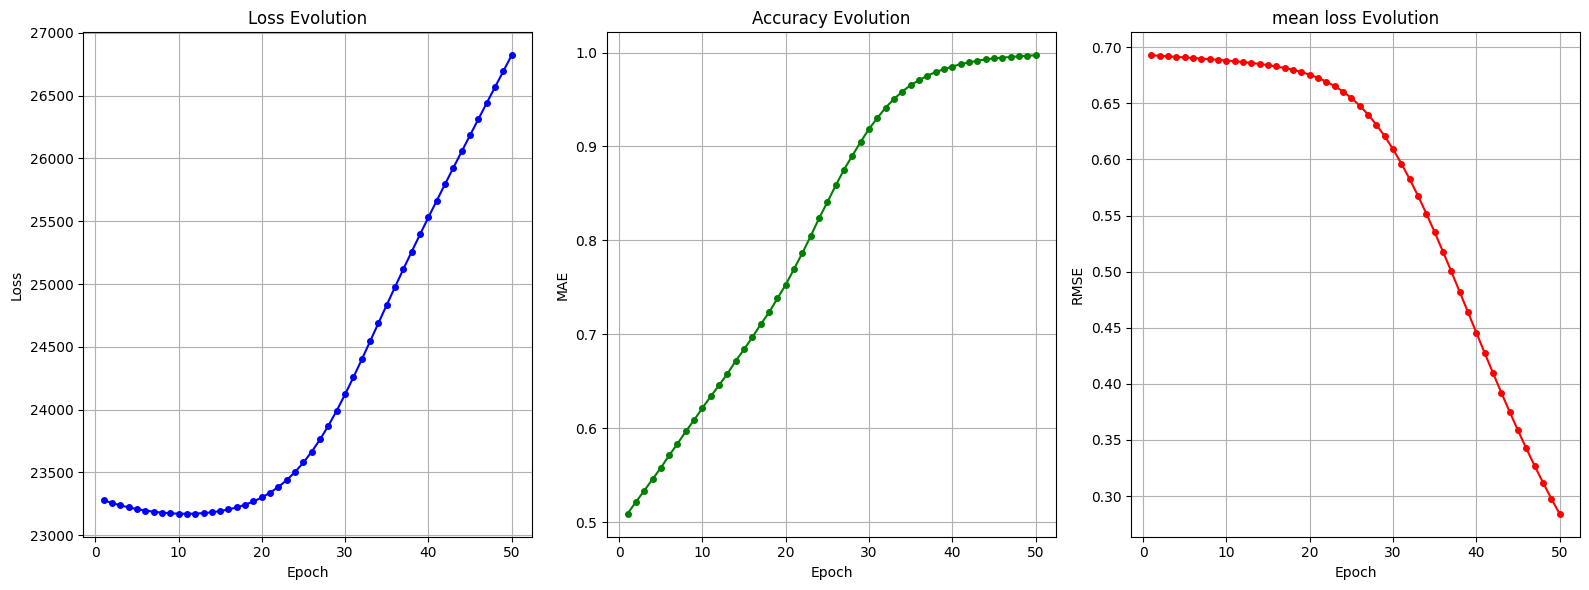

In [46]:
# Plotting Loss, MAE, and RMSE over epochs
plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), loss_evolution, marker='o', color='b', label="Loss",markersize=4)
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plotting MAE
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), mae_evolution, marker='o', color='g', label="MAE",markersize=4)
plt.title('Accuracy Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

# Plotting RMSE
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), rmse_evolution, marker='o', color='r', label="RMSE",markersize=4)
plt.title('mean loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)


plt.tight_layout()
plt.show()

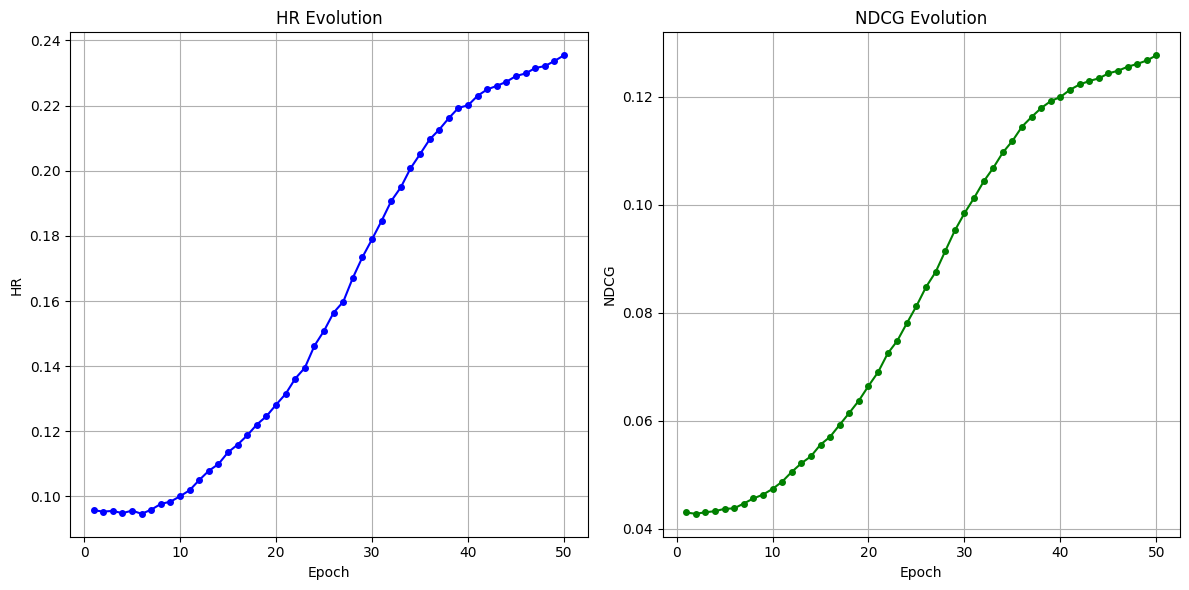

In [47]:
# Plotting HR , NDCG over epochs
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), hr_evolution, marker='o', color='b', label="Loss",markersize=4)
plt.title('HR Evolution')
plt.xlabel('Epoch')
plt.ylabel('HR')
plt.grid(True)

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), ndcg_evolution, marker='o', color='g', label="MAE",markersize=4)
plt.title('NDCG Evolution')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.grid(True)


plt.tight_layout()
plt.show()

### **Evaluation : (test set) RMSE and MAE**

In [ ]:
# After training the model, evaluation using test_data
evaluate_model_leave2_binary(test, P, Q, user_id_map, item_id_map,threshold=0.5, verbose=False)

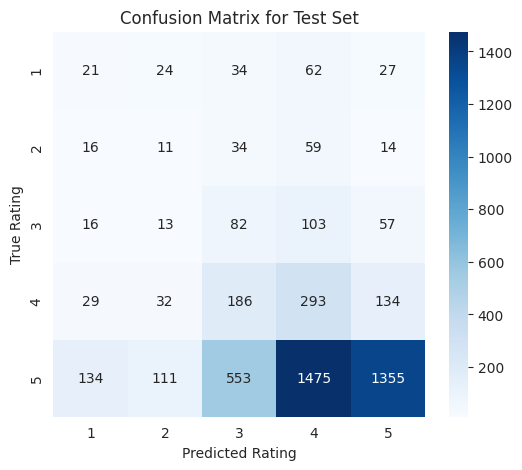

In [117]:

# Prédictions sur l'ensemble de test
y_true = []  
y_pred = []  

for _, row in test_data.iterrows():
    user_id = row['user']
    item_id = row['id']
    true_rating = row['rating']
    
    pred_rating = prediction_rating(user_id, item_id, P, Q, verbose = False)
    
    y_true.append(true_rating)
    y_pred.append(pred_rating)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.show()


### **Prediction  distibution :** 

In [137]:
test_data

,user,id,rating,user_idx,item_idx
7,AE23JYHGEN3D35CHE5OQQYJOW5RA,B09YDBKT7M,5.0,0,7
24,AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BSR996X8,5.0,1,24
31,AE23WLBRYKEC67DM43M6E2MF7GPQ,B07TDNWYSB,5.0,2,31
60,AE23ZFVUOMPKR57BVSWXV34QLMVA,B0BTC9YJ2W,5.0,3,59
68,AE24I2EU3AJAAKBXF367XSV37U6Q,B0C994NVQK,5.0,4,67
...,...,...,...,...,...
42576,AHZPLXCE5YQMLXFFBSURYHZUGMTA,B0BLLXXT6F,5.0,5102,397
42597,AHZQPH7HHSWLUIQFWEQ54NNKKN6A,B0BT9R8MMV,5.0,5103,32
42601,AHZT6MVWNF4GG6FISMZMORKZKK4A,B0BQ4HSKC9,5.0,5104,885
42609,AHZXMBKQJTVG2J7P7EB5WCYTOLDQ,B0C67HCGBR,5.0,5105,210


In [142]:

# Example 1 : 
user_id = "AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ"
item_id = "B0B8F6LD9F"

pred = prediction_rating( user_id , item_id, P, Q )
print("The true rating is  : ")
ratings.query(f'user == "{user_id}" and id == "{item_id}"')

Predicted Rating for user-item pair: 4.00
The true rating is  : 


,user,id,rating,user_idx,item_idx
42624,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B0B8F6LD9F,5.0,5106,20


In [132]:
# Example 2 : 
user_id = "AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ"
item_id = "B095XZJ99J"
pred = prediction_rating( user_id , item_id, P, Q )
print("The true rating is  : ")
ratings.query(f'user == "{user_id}" and id == "{item_id}"')

Predicted Rating for user-item pair: 5.00
The true rating is  : 


,user,id,rating,user_idx,item_idx
42621,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B095XZJ99J,5.0,5106,403


<Axes: ylabel='Count'>

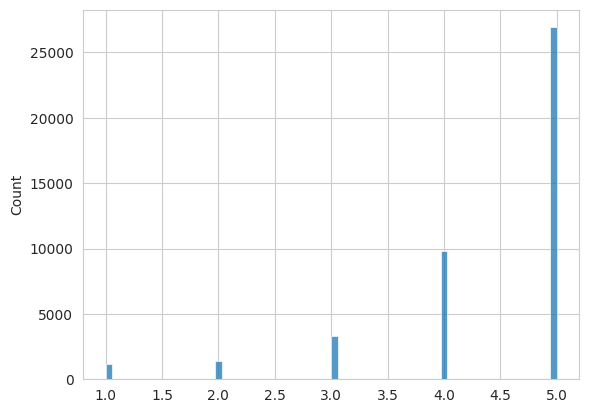

In [46]:

ratings_list = []
for _, row in ratings.iterrows() : 
    user_id = row['user']
    item_id =  row['id']
    pred = prediction_rating( user_id , item_id , verbose = False)
    ratings_list.append(pred)
    
import seaborn as sns
sns.set_style('whitegrid')
sns.histplot(ratings_list)

In [121]:
from ipywidgets import interact

def plot_histogram(epoch):
    ratings_list = []
    
    # Calcul des prédictions pour l'époque sélectionnée
    P_epoch = stored_P[epoch]
    Q_epoch = stored_Q[epoch]

    for _, row in ratings.iterrows():
        user_id = row['user']
        item_id = row['id']
        pred = prediction_rating(user_id, item_id, P_epoch, Q_epoch, verbose = False)
        ratings_list.append(pred)

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_list, bins=5, kde=False, color="blue")
    plt.title(f"Distribution of Predicted Ratings at Epoch {(epoch )*5}")
    plt.xlabel("Predicted Rating")
    plt.ylabel("Frequency")
    plt.show()

# Créer un curseur interactif pour changer l'époque et afficher l'histogramme
interact(plot_histogram, epoch=(0, (num_epochs // 5)+ 1- 1))

interactive(children=(IntSlider(value=5, description='epoch', max=10), Output()), _dom_classes=('widget-intera…

<function __main__.plot_histogram(epoch)>

## **Annexe :**

In [94]:

# Simulation : 
num_users = test_data['user_idx'].max() + 1
num_items = test_data['item_idx'].max() + 1
P = np.random.rand(num_users, 10)  # Dimension utilisateur
Q = np.random.rand(num_items, 10)  # Dimension article

user_id_map = {user: idx for idx, user in enumerate(test_data['user'])}
item_id_map = {item: idx for idx, item in enumerate(test_data['id'])}

# Calcule HR@10 et NDCG@10
hr, ndcg = evaluate_hr_ndcg(test_data, P, Q, user_id_map, item_id_map, K=10)

print(f"HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}")


HR@10: 0.1061, NDCG@10: 0.0499


In [ ]:
########################################################
########## POUR METHODE AVEC LE FICHIER NEGTIVE DIRECT / 

test_negative = pd.read_csv("data/test_negative20_10.csv")



def hit_ratio_and_ndcg(test_data, P, Q, K=10):
    """
    Évalue le modèle sur Hit Ratio (HR) et NDCG.

    Args:
        test_data (DataFrame): Jeu de données test avec colonnes `user`, `id`, `negative_1`, ..., `negative_99`.
        P (ndarray): Matrice des utilisateurs.
        Q (ndarray): Matrice des items.
        K (int): Nombre d'éléments dans le top-K.

    Returns:
        float, float: Moyenne de HR et NDCG sur tous les utilisateurs.
    """
    hits, ndcgs = [], []

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item = row['id']
        negative_items = row[4:].values  # Les colonnes `negative_1` à `negative_99`.

        # Construire la liste des items (1 positif + 99 négatifs)
        items = [positive_item] + list(negative_items)
        
        # Calculer les prédictions pour ces items
        print(f"{items}") ['B09YDBKT7M', 7]
        scores = [prediction_rating(user_id, item_id, P, Q, verbose=False) for item_id in items]

        # Trier les items selon les scores prédits (ordre décroissant)
        ranked_items = np.argsort(scores)[::-1]  # Indices triés par ordre décroissant

        # HR et NDCG pour cet utilisateur
        if 0 in ranked_items[:K]:  # L'élément positif est au rang 0 dans `items`
            hits.append(1)
            rank = np.where(ranked_items == 0)[0][0] + 1  # Rang réel du positif
            ndcgs.append(1 / np.log2(rank + 1))
        else:
            hits.append(0)
            ndcgs.append(0)

    # Moyenne des métriques
    mean_hr = np.mean(hits)
    mean_ndcg = np.mean(ndcgs)

    return mean_hr, mean_ndcg